In [1]:
root_path = '/mnt/storage/fangyijie/fetal_us_planes/'
# lora_path = 'synthetic_lora8/'
# lora 32: synthetic_lora32
# lora 8: synthetic_lora8
sp_train_file = 'spain_train_1150_balanced.csv'
# syn_train_file = 'synthetic_train_5000.csv'
lora_file = 'lora_32.csv'
af_test_file = 'African_test.csv'

### Load Target Labels

In [2]:
import pandas as pd
import random

random.seed(1234)

In [3]:
af_train_df = pd.read_csv(root_path + af_test_file, sep=',')
af_train_df = af_train_df.iloc[:,[1,4]]

# syn_train_df = pd.read_csv(root_path + syn_train_file, sep=',')
syn_train_df = pd.read_csv(root_path + 'synthetic_lora32/' + lora_file, sep=',')
syn_train_df = syn_train_df.iloc[:,[0,1]]

sp_train_df = pd.read_csv(root_path + sp_train_file, sep=',')
sp_train_df = sp_train_df.iloc[:,[2,3]]

In [4]:
print(af_train_df["Plane"].unique())

['Fetal abdomen' 'Fetal femur' 'Fetal brain' 'Fetal thorax']


In [5]:
class2idx = {
    "Other":0,
    "Fetal abdomen":1,
    "Fetal brain":2,
    # "Maternal cervix":3,
    "Fetal femur":4,
    "Fetal thorax":5
}

In [6]:
idx2class = {v: k for k, v in class2idx.items()}

In [7]:
af_train_df["Plane"].replace(class2idx, inplace=True)
syn_train_df["Plane"].replace(class2idx, inplace=True)
sp_train_df["Plane"].replace(class2idx, inplace=True)

In [8]:
# check dataframes
print(af_train_df.head(3))
print(syn_train_df.head(3))
print(sp_train_df.head(3))

   Plane             Image_name
0      1  patient001_DZA_plane0
1      4  patient001_DZA_plane2
2      2  patient001_DZA_plane1
         Image_name  Plane
0  00000-3705861148      1
1  00001-3705861149      1
2  00002-3705861150      1
                     Image_name  Plane
0    Patient01001_Plane1_1_of_1      0
1  Patient00834_Plane1_33_of_34      0
2  Patient00014_Plane1_38_of_42      0


In [9]:
N = 35

In [89]:
sub_af_train_df = af_train_df.groupby('Plane').sample(n=N, random_state=1234)
sub_syn_train_df = syn_train_df.groupby('Plane').sample(n=N, random_state=1234)
sub_sp_train_df = sp_train_df.groupby('Plane').sample(n=N, random_state=1234)

In [90]:
# The African data has no category 'Other'
# Remove 'Other' category from Spanish and synthetic data
sub_syn_train_df = sub_syn_train_df.loc[sub_syn_train_df['Plane'] != 0]
sub_sp_train_df = sub_sp_train_df.loc[sub_sp_train_df['Plane'] != 0]

In [91]:
print(sub_af_train_df.shape)
print(sub_syn_train_df.shape)
print(sub_sp_train_df.shape)

(140, 2)
(140, 2)
(140, 2)


In [92]:
# 1,2,4,5
# "Fetal abdomen":1,
# "Fetal brain":2,
# "Fetal femur":4,
# "Fetal thorax":5
PLANE = 5

In [93]:
sub_af_train_df = sub_af_train_df.loc[sub_af_train_df['Plane'] == PLANE]
sub_syn_train_df = sub_syn_train_df.loc[sub_syn_train_df['Plane'] == PLANE]
sub_sp_train_df = sub_sp_train_df.loc[sub_sp_train_df['Plane'] == PLANE]

In [94]:
# Africa = 1
# Synthesis = 2
# Spain = 3
sub_af_train_df['source'] = 1
sub_syn_train_df['source'] = 2
sub_sp_train_df['source'] = 3

In [95]:
sub_af_train_df = sub_af_train_df.drop(columns=['Plane'])
sub_syn_train_df = sub_syn_train_df.drop(columns=['Plane'])
sub_sp_train_df = sub_sp_train_df.drop(columns=['Plane'])

In [96]:
print(sub_af_train_df.shape)
print(sub_syn_train_df.shape)
print(sub_sp_train_df.shape)

(35, 2)
(35, 2)
(35, 2)


In [97]:
print(sub_af_train_df.head(3))
print(sub_syn_train_df.head(3))
print(sub_sp_train_df.head(3))

               Image_name  source
22  patient033_DZA_plane3       1
89  patient024_EGY_plane3       1
25  patient036_DZA_plane3       1
           Image_name  source
140  00031-1068498591       2
115   00006-672529845       2
142  00033-1068498593       2
                      Image_name  source
964   Patient00845_Plane6_1_of_3       3
921   Patient01155_Plane6_1_of_2       3
1117  Patient01197_Plane6_1_of_1       3


### Build Data Loader

In [98]:
import sys
import torch
import os
import glob
import PIL.Image
import torch.utils.data
import subprocess
import cv2
import numpy as np
import matplotlib.image as img

In [51]:
COMMON_TR = False

In [21]:
import torchvision.transforms as transforms
import torch.nn.functional as F

torch.manual_seed(0)

if COMMON_TR:
    TRANSFORMS = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.RandomRotation(degrees=(-15, 15)),
        transforms.RandomResizedCrop(size=(224, 224), scale=(0.08, 1.0)),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
    ])
else:
    TRANSFORMS = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor(),
        transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
    ])

VAL_TRANSFORMS = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize([0.0, 0.0, 0.0], [1.0, 1.0, 1.0])
])

In [99]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self, root_dir, df, train=False, is_af=False, is_synthetic=False, is_tsne=False, is_lora=False, transform=None, random_hflip=False):
        super(Dataset, self).__init__()
        self.root_dir = root_dir
        self.train = train
        self.transform = transform
        self.random_hflip = random_hflip
        self.is_synthetic = is_synthetic
        self.is_tsne = is_tsne
        self.is_lora = is_lora
        if self.train and is_af:
            self.folder_path = self.root_dir + 'african_cnn_train/'
        elif self.train and self.is_lora:
            self.folder_path = self.root_dir + 'synthetic_lora32/'            
        elif self.train and self.is_synthetic:
            self.folder_path = self.root_dir + 'synthetic_train_5000/'
        elif self.train:
            self.folder_path = self.root_dir + 'Planes_Train/'
        else:
            self.folder_path = self.root_dir + 'african_cnn_test/'

        self.records = df
        self.paths = [self.folder_path + filename + '.png' for filename in self.records['Image_name'].tolist()]

        if self.is_tsne:
            self.labels = self.records['source'].tolist()
        else:
            self.labels = pd.get_dummies(self.records['Plane'].tolist())

            if self.labels.shape[1] == 4:
                self.labels.insert(0, 0, False)
            
            if self.labels.shape[1] == 1:
                self.labels.insert(1, 1, False)
                self.labels.insert(2, 2, False)
                self.labels.insert(3, 4, False)
                self.labels.insert(4, 5, False)

        self.transform = transform

    def __len__(self):
        return len(self.paths)

    def __getitem__(self, index):
        image = cv2.imread(self.paths[index], cv2.IMREAD_COLOR) #load US images
        image = PIL.Image.fromarray(image)
        #image = PIL.Image.open(self.paths[index]).convert('RGB')
        #image = img.imread(self.paths[index])
        if self.is_tsne:
            label = self.labels[index]
            label = torch.Tensor([label]) #convert type from numpy to torch
        else:
            label = self.labels.iloc[index].tolist() #get label of ultrasound image
            label = torch.Tensor(label) #convert type from numpy to torch

        if self.transform is not None:
            image = self.transform(image)

        #if self.random_hflip and float(np.random.random(1)) > 0.5:
        #    image = torch.from_numpy(image.numpy()[..., ::-1].copy())

        image = torch.from_numpy(image.numpy()[..., ::])

        return image, label

### Build Pre-Trained Model


In [23]:
import torch
import torchvision
import torchvision.transforms as transforms
from PIL import Image
from tqdm import tqdm

from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np
from sklearn import metrics

In [100]:
import torch
import torchvision
from torchvision.models import Inception_V3_Weights

#device = torch.device('cuda')
device = torch.device('cuda:1' if torch.cuda.is_available() else 'cpu')
output_dim = len(class2idx)  # 5 categories for classification

# Inception V3
m_name = 'inception'
model = torchvision.models.inception_v3(weights=Inception_V3_Weights.IMAGENET1K_V1)

model = model.to(device)


In [ ]:
print(model)

### Dataset Preparation

In [101]:
af_dataset = Dataset(root_dir=root_path, 
                        df=sub_af_train_df, 
                        train=False, 
                        is_af=True,
                        is_synthetic=False,
                        is_tsne=True,
                        transform=TRANSFORMS, 
                        random_hflip=False)

In [102]:
syn_dataset = Dataset(root_dir=root_path, 
                        df=sub_syn_train_df, 
                        train=True, 
                        is_af=False,
                        is_synthetic=True,
                        is_tsne=True,
                        is_lora=True,
                        transform=TRANSFORMS, 
                        random_hflip=False)

In [103]:
sp_dataset = Dataset(root_dir=root_path, 
                        df=sub_sp_train_df, 
                        train=True, 
                        is_af=False,
                        is_synthetic=False,
                        is_tsne=True,
                        transform=TRANSFORMS, 
                        random_hflip=False)

In [79]:
from torch.utils.data import ConcatDataset, DataLoader

BATCH_SIZE = 24  # 64 could cause "out of memory error"

In [104]:
test_dataset = ConcatDataset([af_dataset, syn_dataset, sp_dataset])
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=0, drop_last=False)

In [31]:
print(f'test data size: {len(test_dataset)}')

test data size: 105


### Image Features

In [105]:
model.eval()

Inception3(
  (Conv2d_1a_3x3): BasicConv2d(
    (conv): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2a_3x3): BasicConv2d(
    (conv): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_2b_3x3): BasicConv2d(
    (conv): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    (bn): BatchNorm2d(64, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (maxpool1): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  (Conv2d_3b_1x1): BasicConv2d(
    (conv): Conv2d(64, 80, kernel_size=(1, 1), stride=(1, 1), bias=False)
    (bn): BatchNorm2d(80, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  )
  (Conv2d_4a_3x3): BasicConv2d(
    (conv): Conv2d(80, 192, kernel_size=(3, 3), stri

In [106]:
features = None
labels = None

for image, target in iter(tqdm(test_loader)):
    image = image.to(device)
    target = target.to(device)

    target_label = target.cpu().data.numpy()  # for GPU
    if labels is None:
        labels = target_label
    else:
        labels = np.concatenate((labels, target_label))
 
    output = model(image)
 
    current_outputs = output.cpu().data.numpy()
    if features is None:
        features = current_outputs
    else:
        features = np.concatenate((features, current_outputs))

100%|██████████| 5/5 [00:00<00:00,  7.04it/s]


### Start Visualization

In [83]:
from sklearn.manifold import TSNE
import seaborn as sns

In [35]:
features.shape

(105, 1000)

In [107]:
tsne = TSNE(n_components=2).fit_transform(features)

In [108]:
# scale and move the coordinates so they fit [0; 1] range
def scale_to_01_range(x):
    # compute the distribution range
    value_range = (np.max(x) - np.min(x))
 
    # move the distribution so that it starts from zero
    # by extracting the minimal value from all its values
    starts_from_zero = x - np.min(x)
 
    # make the distribution fit [0; 1] by dividing by its range
    return starts_from_zero / value_range

In [109]:
# extract x and y coordinates representing the positions of the images on T-SNE plot
tx = tsne[:, 0]
ty = tsne[:, 1]
 
tx = scale_to_01_range(tx)
ty = scale_to_01_range(ty)

In [110]:
colors_per_class = [1, 2, 3]
# sns_colors = sns.color_palette("hls").as_hex()
sns_colors = ['#009392','#eeb479','#cf597e']
# Africa = 1
# Synthesis = 2
# Spain = 3
new_labels = ['Africa','Synthesis','Spain']

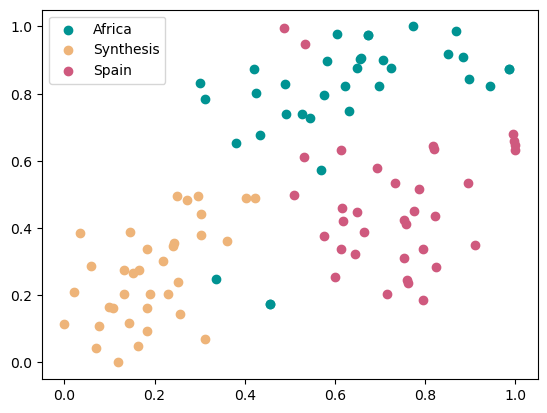

In [111]:
# initialize a matplotlib plot
fig = plt.figure()
ax = fig.add_subplot(111)
 
# for every class, we'll add a scatter plot separately
for label in colors_per_class:
    # find the samples of the current class in the data
    indices = [i for i, l in enumerate(labels) if l == label]
 
    # extract the coordinates of the points of this class only
    current_tx = np.take(tx, indices)
    current_ty = np.take(ty, indices)
 
    # convert the class color to matplotlib format
    color = sns_colors[label-1]
 
    # add a scatter plot with the corresponding color and label
    ax.scatter(current_tx, current_ty, c=color, label=label)
 
# build a legend using the labels we set previously
ax.legend(loc='best', labels=new_labels)
 
# finally, show the plot
plt.show()